In [0]:
import pandas as pd
import numpy as np
import datetime
import time
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

ticker = 'F'
dt_today = int(datetime.datetime.today().timestamp())
dt_5yrs_ago = int((datetime.datetime.today() + relativedelta(years=-5)).timestamp())
url = 'https://query1.finance.yahoo.com/v7/finance/download/'+ticker+'?period1='+str(dt_5yrs_ago)+'&period2='+str(dt_today)+'&interval=1d&events=history'

In [253]:
data = pd.read_csv(url)
data.Date = pd.to_datetime(data.Date)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-20,15.89,15.92,15.82,15.91,12.195364,15250800
1,2015-04-21,15.92,15.98,15.76,15.82,12.126377,18509500
2,2015-04-22,15.83,15.93,15.72,15.91,12.195364,20312100
3,2015-04-23,15.84,15.90,15.70,15.76,12.080387,28458000
4,2015-04-24,15.73,15.87,15.70,15.77,12.088052,20293300
...,...,...,...,...,...,...,...
1254,2020-04-13,5.43,5.43,5.02,5.16,5.160000,99320000
1255,2020-04-14,5.27,5.44,5.16,5.29,5.290000,74877000
1256,2020-04-15,5.06,5.14,4.95,5.03,5.030000,74727700
1257,2020-04-16,5.06,5.07,4.89,4.94,4.940000,58005800


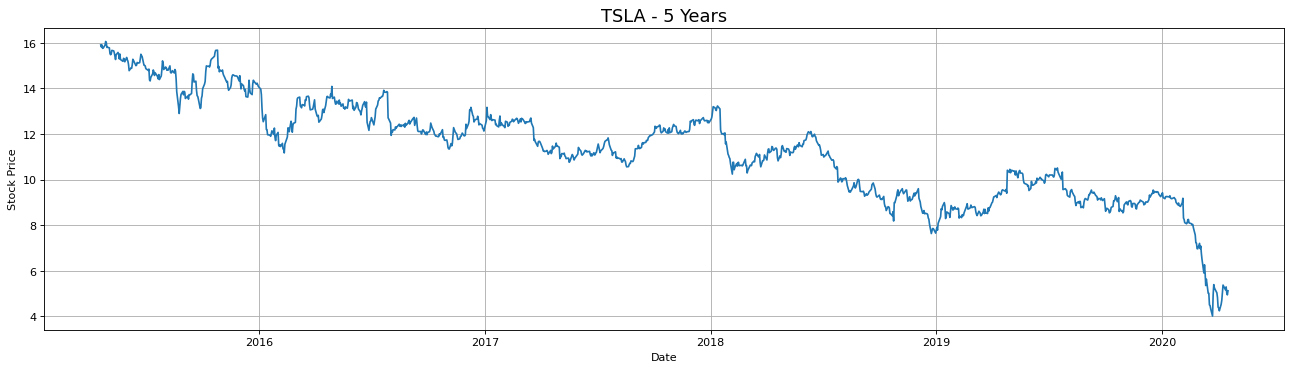

In [254]:
figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data.Date, data.Close)
plt.title("TSLA - 5 Years", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid()

In [255]:
df = data[['Date', 'Close']]
print('Shape of dataframe is: ', df.shape)
df.head()

Shape of dataframe is:  (1259, 2)


,Date,Close
0,2015-04-20,15.91
1,2015-04-21,15.82
2,2015-04-22,15.91
3,2015-04-23,15.76
4,2015-04-24,15.77


# Moving Average Model

In [256]:
# First we will try to start with a moving average prediction
train = df[:1200]
valid = df[1200:]
print('Shape of training data is ', train.shape)
print('Shape of test data is ', valid.shape)

Shape of training data is  (1200, 2)
Shape of test data is  (59, 2)


In [257]:
averages = [50, 100, 200]
def moving_average(ma):
  preds = []
  for i in range(0, len(valid)):
    a = train['Close'][len(train)-ma+i:].sum() + sum(preds)
    b = a/ma
    preds.append(b)
  return preds

comparison_df = valid.reset_index()

for i in averages:
  ma = moving_average(i)
  ma = pd.DataFrame(ma, columns=['ma_'+ str(i)])
  comparison_df = comparison_df.merge(ma, left_index=True, right_index=True)

comparison_df.head()

,index,Date,Close,ma_50,ma_100,ma_200
0,1200,2020-01-24,9.00,9.148000,9.080100,9.438450
1,1201,2020-01-27,8.89,9.149360,9.079201,9.439592
2,1202,2020-01-28,8.97,9.151547,9.078993,9.440140
3,1203,2020-01-29,8.86,9.158378,9.077783,9.440391
4,1204,2020-01-30,8.84,9.165746,9.075161,9.440343


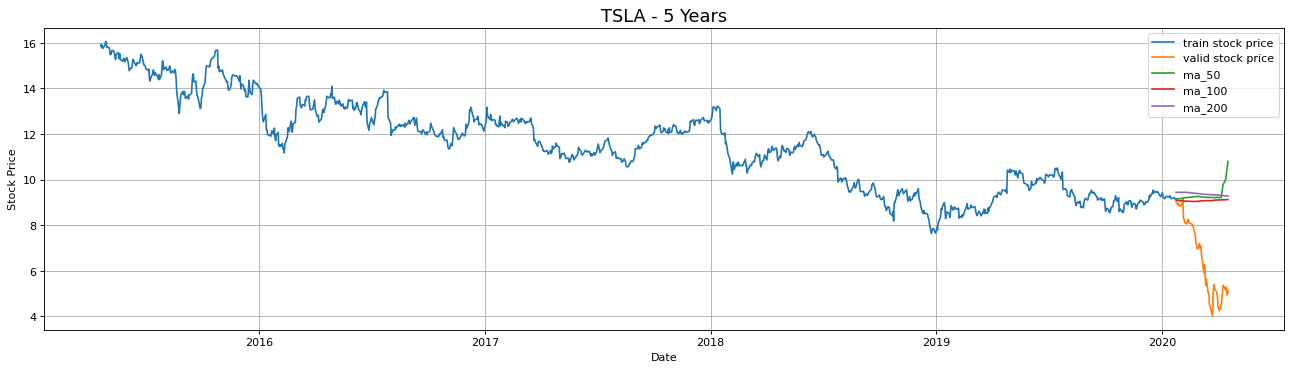

In [258]:
labels = ['train stock price', 'valid stock price']
figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
plt.clf()
plt.plot(train.Date, train.Close)
plt.plot(valid.Date, valid.Close)
for i in averages:
  plt.plot(comparison_df.Date, comparison_df['ma_'+str(i)])
  labels.append('ma_'+str(i))

plt.title("TSLA - 5 Years", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend(labels)
plt.grid()

In [259]:
def rmse(a):
  evaluation = []
  index_labels = []
  for i in a:
    rmse = np.sqrt(np.mean(np.power(np.array(comparison_df.Close) - np.array(comparison_df['ma_'+str(i)]),2)))
    evaluation.append(rmse)
    index_labels.append('ma_'+str(i))
  evaluation = pd.DataFrame(evaluation, index=index_labels)
  evaluation.rename(columns={0: 'rmse'}, inplace = True)
  return evaluation

rmse(averages)

,rmse
ma_50,3.322021
ma_100,3.038042
ma_200,3.257028


# fbProphet

In [0]:
from fbprophet import Prophet

In [261]:
df.rename(columns={'Date': 'ds', 'Close':'y'}, inplace=True)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,2015-04-20,15.91
1,2015-04-21,15.82
2,2015-04-22,15.91
3,2015-04-23,15.76
4,2015-04-24,15.77


In [262]:
train = df[:1200]
valid = df[1200:]
print('Shape of training data is ', train.shape)
print('Shape of test data is ', valid.shape)

Shape of training data is  (1200, 2)
Shape of test data is  (59, 2)


In [263]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=len(valid))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [264]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1254,2020-03-18,9.215208,8.604182,9.800530
1255,2020-03-19,9.189739,8.574346,9.811929
1256,2020-03-20,9.181562,8.585285,9.774201
1257,2020-03-21,9.649555,9.055023,10.232011
1258,2020-03-22,9.643981,9.040475,10.282119


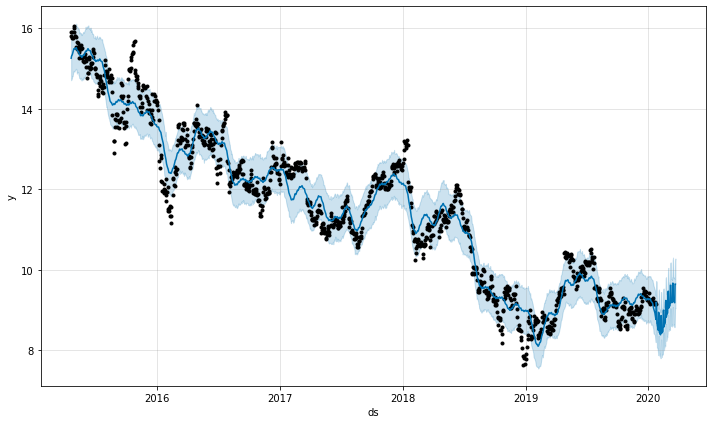

In [265]:
fig1 = m.plot(forecast)

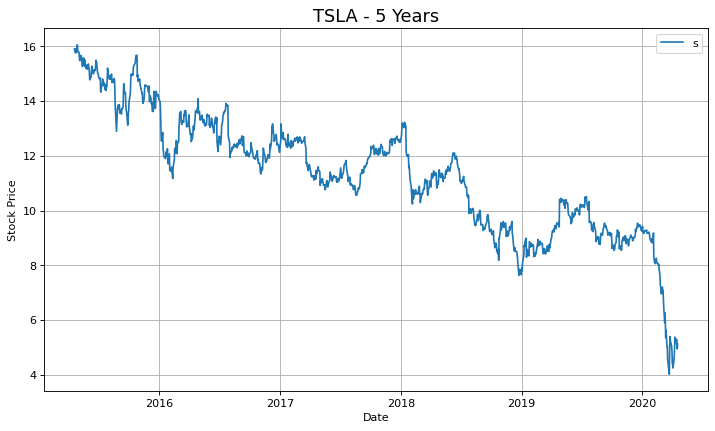

In [266]:
figure(num=None, figsize=(10.7, 6), dpi=80, facecolor='w', edgecolor='k')
plt.clf()
plt.plot(df.ds, df.y)
plt.title("TSLA - 5 Years", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend('stocl price')
plt.grid()

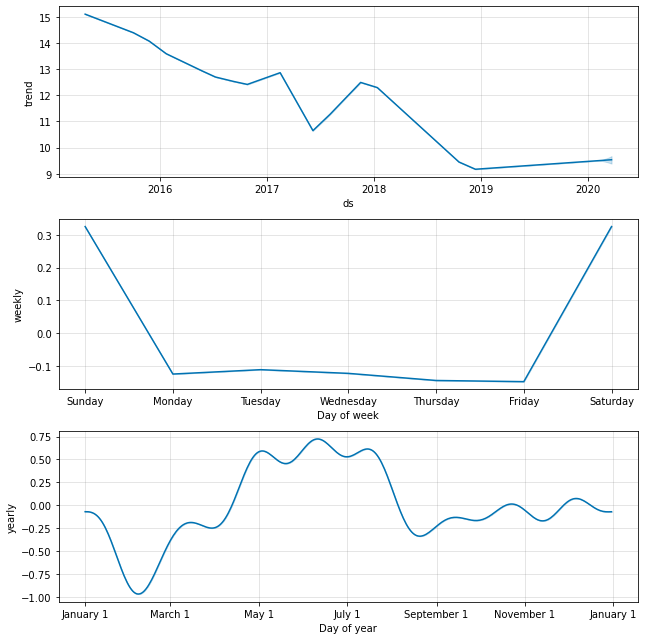

In [267]:
fig2 = m.plot_components(forecast)

In [280]:
# changepoint_range=0.80
m = Prophet(changepoint_prior_scale=0.1)
m.add_country_holidays(country_name='US')
m.fit(df)
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1314,2020-06-12,6.100164,5.336119,6.829086
1315,2020-06-13,5.657588,4.903593,6.372809
1316,2020-06-14,5.648460,4.852565,6.419440
1317,2020-06-15,6.098406,5.351442,6.768841
1318,2020-06-16,6.101058,5.388408,6.879804


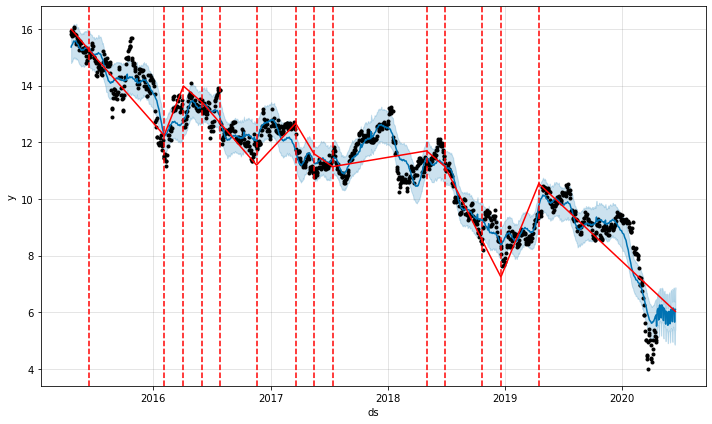

In [281]:
from fbprophet.plot import add_changepoints_to_plot
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

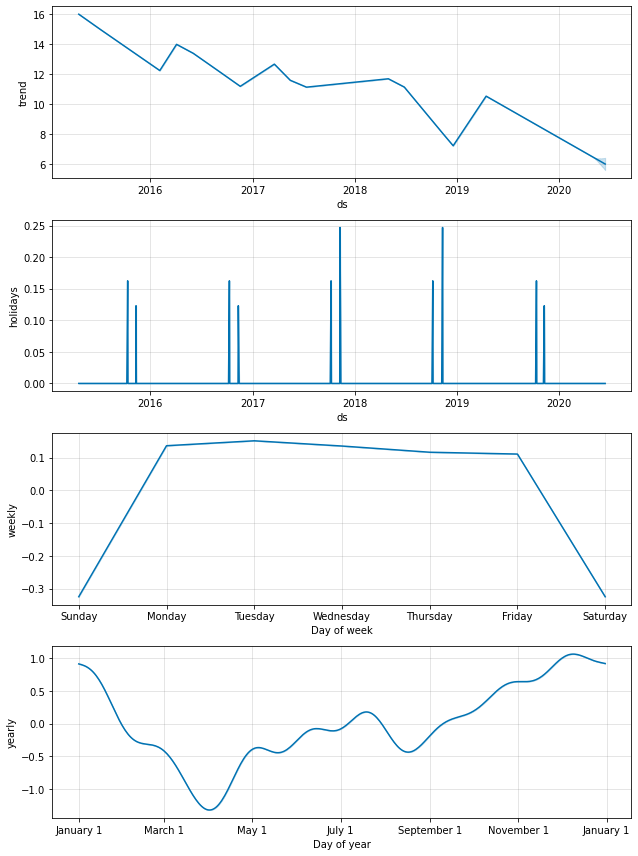

In [282]:
fig2 = m.plot_components(forecast)